In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os

from matplotlib.lines import Line2D

#### Author:
Simon Hackl, 28.02.2021

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S7_assemblyEvaluation.sh` script regarding the sub-sample assemblies. In order to use this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

####  Comparing predicted with annotated genes:

In the following, methods to visualize selected features of the `Quast` reports regarding the sub-sample assemblies are defined.

In [2]:
def getFeature( feature, assembler, dataFrames ) :
    ''' Returns a list of the values of one feature of a `Quast` report of one assembler.
    
    Parameters
    ----------
    feature : str
        Specifies the feature of the Quast report for which the values are returned.
        
    assembler : str
        Specifies the assembler for which the values are returned.
        
    dataFrames : dict
        A dictionary containing panda.DataFrame objects accessible via the respective coverage of the
        read sub sample for which the report was calculated. Each dataframe should contain the features as rows
        and assemblers as columns.
    '''
    # To access the specified feature, the passed rows referring to this feature of each dataframe
    # is merged in one new dataframe.
    keys = list( dataFrames.keys( ) )
    dataFrameMerged = pd.concat( [ dataFrames[ k ].loc[ feature ] for k in keys ], axis=1 )
    dataFrameMerged.columns = keys
    # Quast reports detected genomic features as complete and partly detected genomic features.
    # Therefore, if this feature is passed the contained values have to be parsed first to report
    # only complete features.
    if feature == "# genomic features" :
        complete = [ ]
        partly = [ ]
        for i in dataFrameMerged.loc[ assembler ].tolist( ) :
            if type( i ) == str and i != "nan" :
                completeGenes, partlyGenes = i.split( "+" )
                completeGenes = float( completeGenes.strip( ) )
                partlyGenes = float( partlyGenes.strip( "part" ).strip( ) )
                complete.append( completeGenes )
                partly.append( partlyGenes )
            else :
                complete.append( float( "nan" ) )
                partly.append( float( "nan" ) )
        return [ complete, partly ]
    else :
        return [ [ float( i ) for i in dataFrameMerged.loc[ assembler ].tolist( ) ] ]

In [3]:
def plotFeatures( features, assemblers, dataFrames, genomeFeatureCount, linewidth = False, marker = [ ".", "x", "+" ], markersize = False, colors = False, size = 10,
                 title = "", ylabels = False, xlabel = "depth of coverage", altXticks = False, legendAppend = "" ) :
    ''' Visualizes the values returned by the `getFeature` method. Thereby one plot for each passed feature is generated
    depicting the reported values for different coverages of all assemblers specified in assemblers.
    
    Parameters
    ----------
    
    features : list
        A list of strings specifying Quast report features. These features should be named exactly as in the
        Quast report.
        
    assemblers : list
        A list of strings specifying assemblers to consider. These assemblers should be named exactly as in the
        Quast report.
        
    dataFrames : dict
        A dictionary containing panda.DataFrame objects accessible via the respective coverage of the
        read sub sample for which the report was calculated. Each dataframe should contain the features as rows
        and assemblers as columns.
    
    genomeFeatureCount : int
        The number of reference genomic features of the sample for which the Quast reports were calculated.
        The value is used to report the number of genomic features as percentage relative to the total number
        of reference featrues.
        
    linewidth : False or float
        If set to False, the linewidht is computed as 0.05 * size. If a float is specified this value is used.
        Default is False
        
    marker : list
        A list of pyplot marker symbol names used to represent the data points for different assemblers. The list
        should be at least as long as the number of passed assemblers.
        Default is [ ".", "x", "+" ]
        
    markersize : False or float
        If set to False, the markersize is computed as 1 * size. If a float is specified this value is used.
        Default is False
    
    colors : False or dictionary
        If set to False, the plot will be drawn in black. If a dictionary is passed it should contain the passed
        assemblers as keys and each should refer to a pyplot color name. Default is False.
    
    size : float
        The size of the plot, passed as figsize parameter to pyplot.subplots. Default is 10.
    
    title : str
        The super title of the plot to print.
    
    ylabels : False or dictionary
        If set to False, the features names will be used as y-labels. If a dictionary is passed it should contain the passed
        features as keys and each should refer to a string which is used as y-label. Default is False.
    
    xlabel : str
        The label of the x-axis. Default is "depth of coverage".
    
    altXticks : False or list
        Alternative x-tick labels. If False is passed, the keys of dataFrames are used as x-tick labels. Default is False
    
    legendAppend : str
        An optional string that is appended to the labels printed in the legend. Default is the empty string.
    '''
    fig, axs = plt.subplots( nrows = len( features ), ncols = 1,
                             figsize = ( size, ( size / ( 1.618 / 0.3 ) ) * len( features ) ) )
    keys = list( dataFrames.keys( ) )
    
    # Compute alternative x-ticks and plot component sizes depending on the input parameters.
    xticks =  altXticks if altXticks else [ int( k.strip( "X" ) ) for k in keys ]
    largeTextSize = size * 1.5
    smallTextSize = size * 1.3
    markersize = markersize if markersize else 1 * size
    linewidth = linedwidth if linewidth else 0.05 * size
    
    # For each feature the respective axis is accessed and used for plotting the values of this feature.
    for i in range( 0, len( features ) ) :
        feature = features[ i ]
        ax = axs[ i ]
        # For each of the passed assembler call the `getFeature` method with the current feature.
        for j in range( 0, len( assemblers ) ) :
            assembler = assemblers[ j ]
            featureValues = getFeature( feature, assembler, dataFrames )[ 0 ]
            # Convert the '# genomic features' feature into a percentage.
            if feature == "# genomic features" :
                featureValues = [ ( x / genomeFeatureCount ) * 100 for x in featureValues ]
            ax.plot(
                np.arange( 0, len( xticks ) ), featureValues,
                linewidth = linewidth, 
                marker = marker[ j ], 
                markersize = markersize, 
                color = colors[ assembler ] if colors else "black",
                label = assembler + legendAppend
            )
        # The x-axis label and tick labels are only plotted for the last plot.
        if i == len( features ) - 1 :
            ax.set_xticklabels( xticks )
            ax.set_xlabel( xlabel, fontsize = largeTextSize )
        else :
            ax.set_xticklabels( [ " " ] * len( xticks ) )
        # For each subplot the y-label and tick labels are adjusted according to the passed parameters.
        ax.set_xticks( np.arange( 0, len( xticks ) ) )
        ax.tick_params( axis = "x", labelsize = smallTextSize )
        ax.tick_params( axis = "x", which = "minor", bottom = False, top = False)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor" )
        
        ax.set_ylabel( ylabels[ feature ]  if ylabel else feature, fontsize = largeTextSize, rotation = 0, horizontalalignment='left', verticalalignment='center' )
        ax.yaxis.set_label_coords( size * -0.029, 0.5 )
        ax.tick_params( axis = "y", labelsize = smallTextSize, rotation = 20 )
    
    # Print the legend only once on top of the plot and show the plot.
    plt.legend( loc="upper left", bbox_to_anchor=(0.0,len( features ) + 1.5), fontsize = smallTextSize, ncol=len(assemblers) )
    plt.show( )

Next, the features to extract from the Quast reports, the coverage to identify the Quast reports and colors and y-labels are specified.

In [4]:
features = [ "# mismatches", "# indels", "# misassemblies", "# genomic features", "# contigs", "Genome fraction (%)",  ]
covs = [ "200X", "150X", "100X", "80X", "60X", "40X", "20X", "15X", "10X", "8X", "6X", "4X", "2X", "1X" ]
colors = {
        "canu": "cornflowerblue",
        "canu_medaka": "lightcoral",
        "flye": "black",
        "raven": "black",
        "unicycler~longread": "black",
        "unicycler~hybrid": "black",
        "trycycler": "cornflowerblue",
        "trycycler_medaka": "lightcoral",
        "trycycler_medaka_pilon": "gold"
    }
ylabel = {
    "# mismatches" : 'number of\nmismatches',
    "# indels" : 'number of\nindels',
    "# genomic features" : '% of genes\nrecovered',
    "# contigs" : 'number of\ncontigs',
    "Genome fraction (%)" : '% of genome\nreconstructed',
    "# misassemblies": 'number of\nmisassemblies'
}

To run the visualization for the CFT073 sub sample assemblies, the respective reports are parsed in, the alternative x-tick labels are set to the true depths of coverages computed with `S5_coverageAnalysis.sh` and the genomic features are set to the number reported in the Quast report of the non sub sample CFT073 assembly evaluation.

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


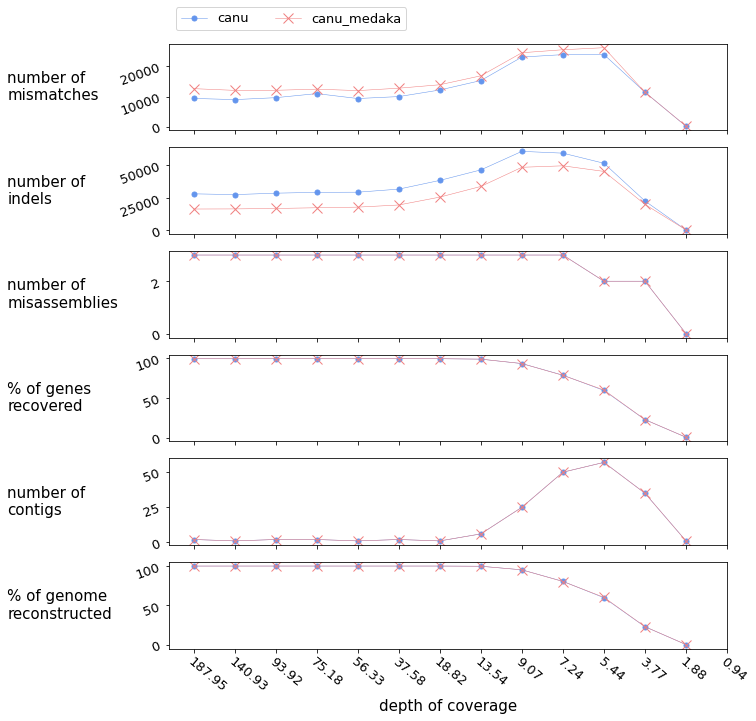

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


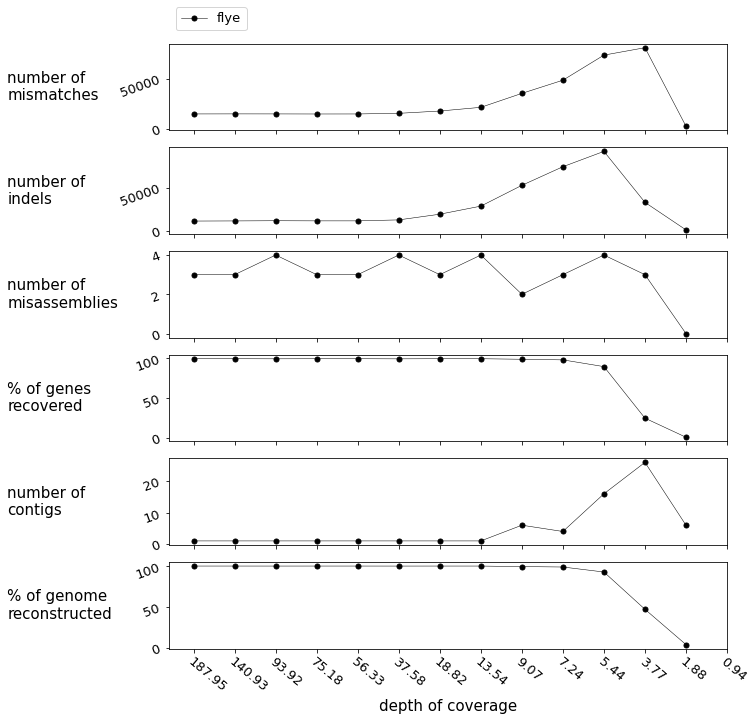

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


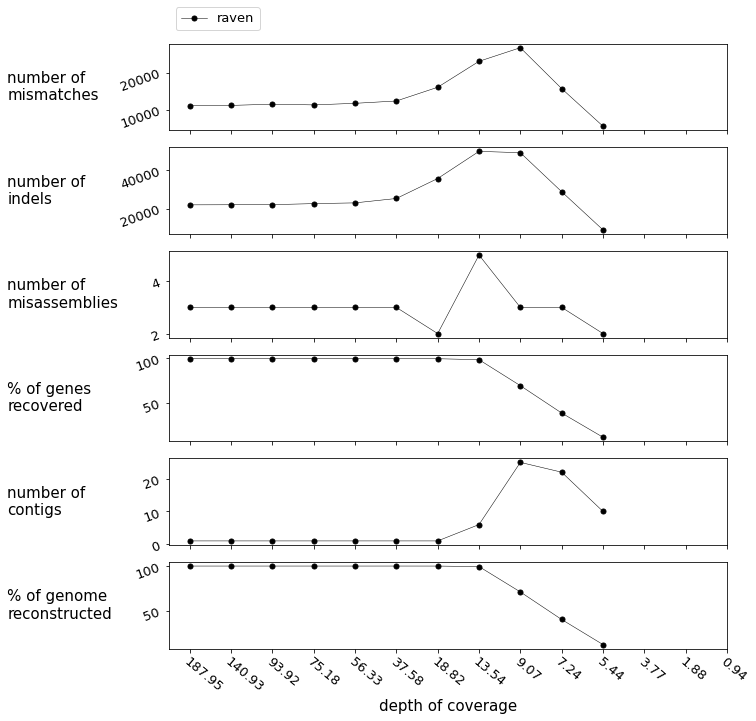

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


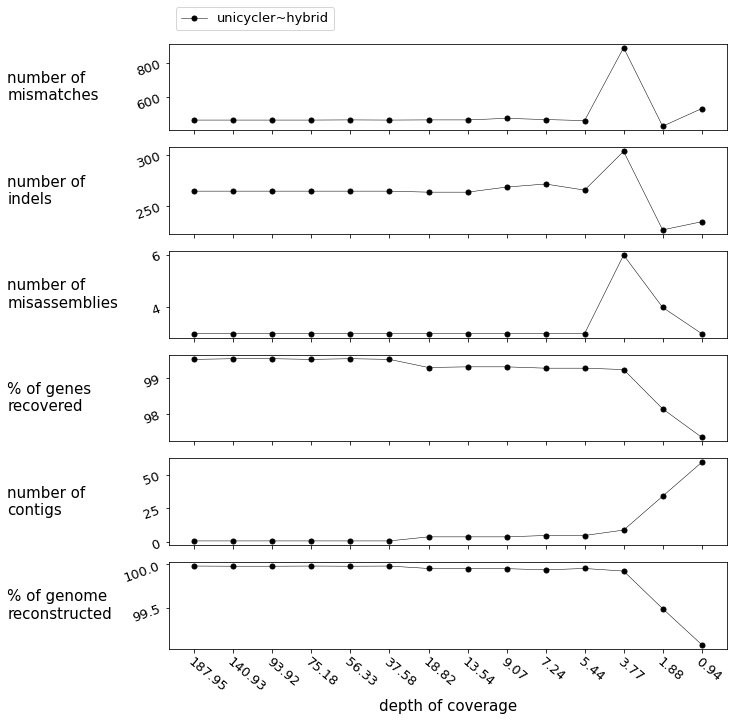

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


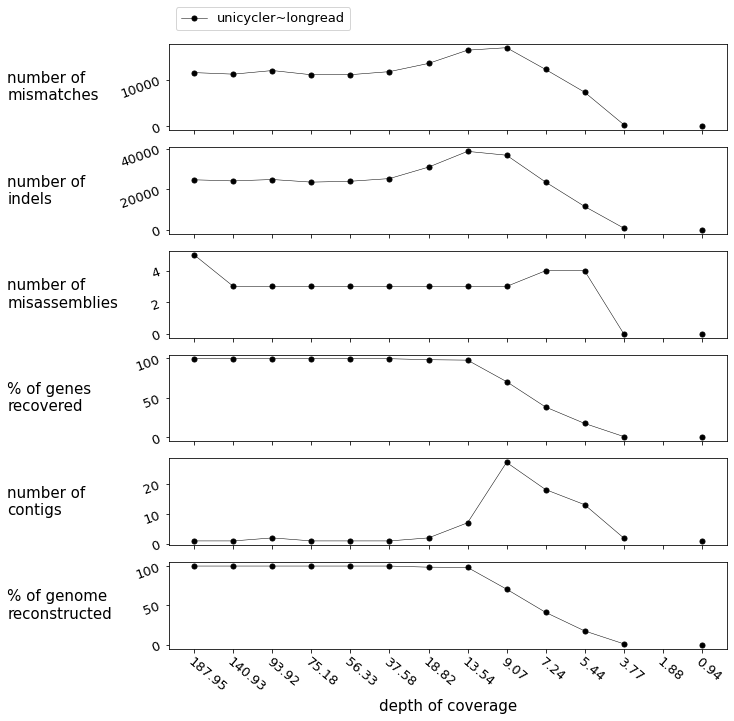

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


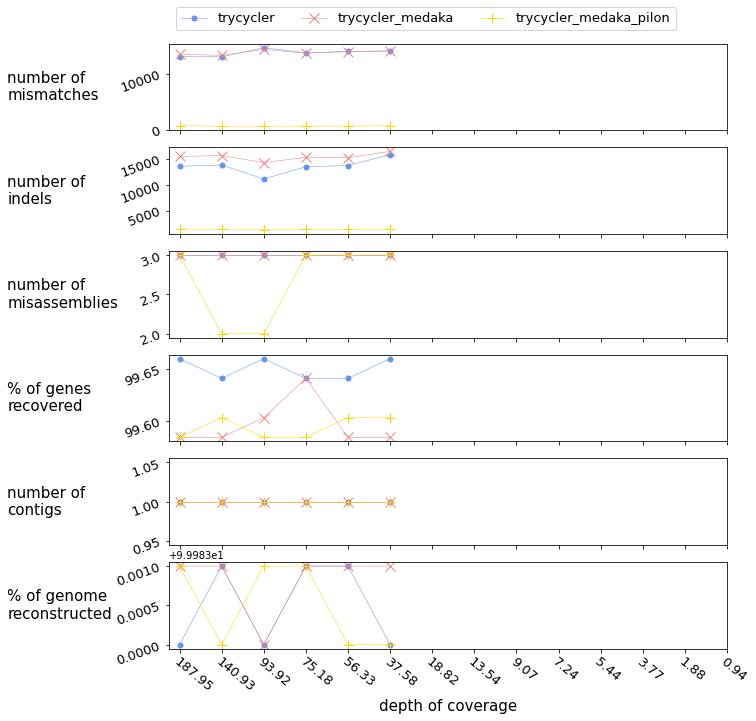

In [5]:
dfs = { }
for cov in covs :
    dfs[ cov ] = pd.read_csv(open('./results/quast/CFT073~' + cov + '/report.tsv'), delimiter='\t')
    dfs[ cov ].set_index("Assembly",inplace=True)

altXticks = [ 187.95, 140.93, 93.92, 75.18, 56.33, 37.58, 18.82, 13.54, 9.07, 7.24, 5.44, 3.77, 1.88, 0.94 ]
genomicFeatures = 5288

plotFeatures( features, ["canu","canu_medaka"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

plotFeatures( features, ["flye"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

plotFeatures( features, ["raven"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

plotFeatures( features, ["unicycler~hybrid"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

plotFeatures( features, ["unicycler~longread"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

plotFeatures( features, ["trycycler","trycycler_medaka","trycycler_medaka_pilon"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks )

To run the visualization for the RN4220 sub sample assemblies, the respective reports are parsed in, the alternative x-tick labels are set to the true depths of coverages computed with `S5_coverageAnalysis.sh` and the genomic features are set to the number reported in the Quast report of the non sub sample CFT073 assembly evaluation.

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


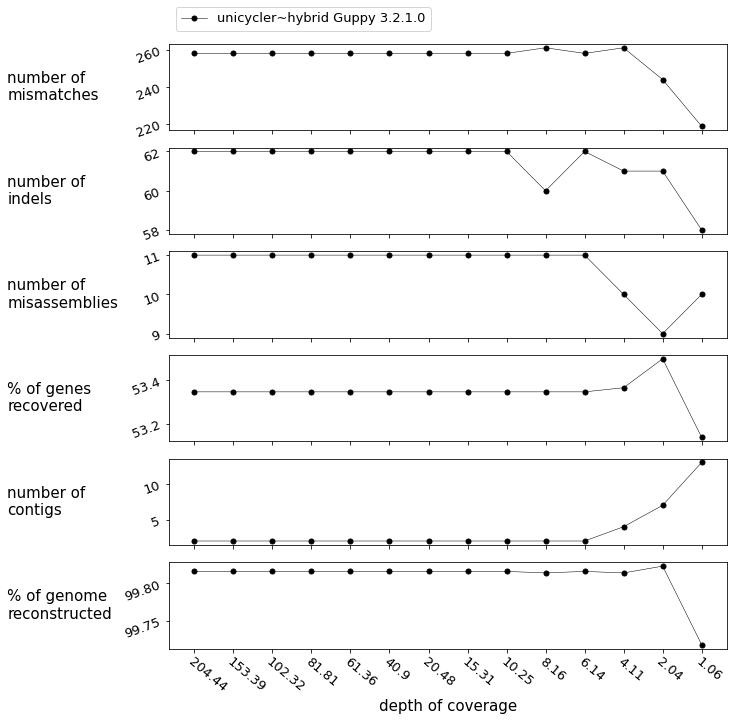

<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [ " " ] * len( xticks ) )
<ipython-input-3-54e0fa08c471>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticks )


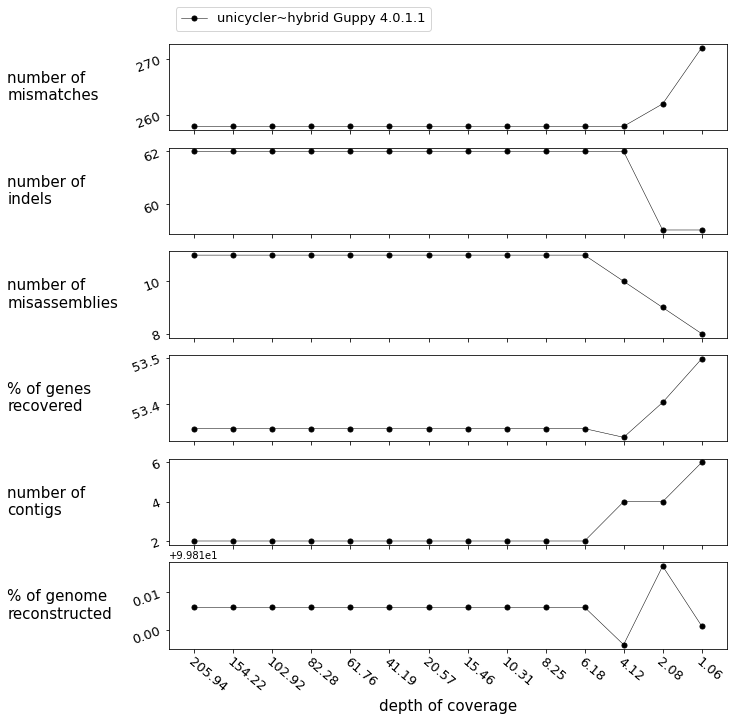

In [6]:
genomicFeature = 2913

dfs = { }
for cov in covs :
    dfs[ cov ] = pd.read_csv(open('./results/quast/RN4220~guppy3210~' + cov + '/report.tsv'), delimiter='\t')
    dfs[ cov ].set_index("Assembly",inplace=True)
altXticks = [ 204.44, 153.39, 102.32, 81.81, 61.36, 40.9, 20.48, 15.31, 10.25,8.16, 6.14, 4.11, 2.04, 1.06 ]
plotFeatures( features, ["unicycler~hybrid"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks, legendAppend= " Guppy 3.2.1.0" )

dfs = { }
for cov in covs :
    dfs[ cov ] = pd.read_csv(open('./results/quast/RN4220~guppy4011~' + cov + '/report.tsv'), delimiter='\t')
    dfs[ cov ].set_index("Assembly",inplace=True)
altXticks = [ 205.94, 154.22, 102.92, 82.28, 61.76, 41.19, 20.57, 15.46, 10.31, 8.25, 6.18, 4.12, 2.08, 1.06 ]
plotFeatures( features, ["unicycler~hybrid"], dfs, genomicFeatures, size = 10, colors = colors, ylabels = ylabel, altXticks = altXticks, legendAppend= " Guppy 4.0.1.1" )